# imports

In [1]:
import pandas as pd
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
import phik 
from phik.report import plot_correlation_matrix
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import root_mean_squared_error
import optuna

import warnings
warnings.filterwarnings("ignore")

# data loading

In [2]:
df = pd.read_csv('stage_1_regression_train.csv')
df

,target,relative_humidity_2m,dew_point_2m,cloud_cover,wind_speed_10m,wind_direction_10m,uv_index,is_day,sunshine_duration,shortwave_radiation
0,13.0040,79.0,9.446486,100.0,8.905908,345.963700,1.90,1.0,699.35077,332.0
1,16.2040,62.0,8.914721,100.0,10.464798,3.945108,0.25,1.0,0.00000,73.0
2,13.5040,82.0,10.490725,50.0,3.396233,327.994660,0.00,0.0,0.00000,0.0
3,11.8540,95.0,11.078381,24.0,4.072935,135.000100,0.00,0.0,0.00000,0.0
4,20.3040,60.0,12.285676,0.0,7.594208,328.570500,0.40,1.0,3600.00000,163.0
...,...,...,...,...,...,...,...,...,...,...
4084,19.0040,51.0,8.637112,97.0,12.889810,35.909817,1.75,1.0,3600.00000,378.0
4085,21.9535,71.0,16.455479,100.0,9.346143,164.357700,3.30,1.0,3144.71100,323.0
4086,1.3035,91.0,-0.003951,87.0,2.545584,261.870000,0.00,0.0,0.00000,0.0
4087,17.1540,76.0,12.887712,100.0,7.289445,212.905240,2.90,1.0,3600.00000,430.0


In [3]:
pred_df = pd.read_csv('stage_1_regression_test_features.csv', index_col=0)
pred_df

,relative_humidity_2m,dew_point_2m,cloud_cover,wind_speed_10m,wind_direction_10m,uv_index,is_day,sunshine_duration,shortwave_radiation
index,,,,,,,,,
0,54.0,6.139822,0.0,2.520000,180.000000,0.05,0.0,0.0000,6.0
1,92.0,9.208817,100.0,9.504273,245.376450,0.00,1.0,0.0000,17.0
2,89.0,15.768355,98.0,4.104631,217.875050,0.00,0.0,0.0000,0.0
3,64.0,13.176939,13.0,6.569383,350.537750,1.30,1.0,3600.0000,143.0
4,62.0,12.596930,100.0,9.726664,218.991000,2.95,1.0,2469.8354,273.0
...,...,...,...,...,...,...,...,...,...
1018,96.0,-1.404214,72.0,5.804825,262.875100,0.05,1.0,0.0000,10.0
1019,95.0,16.494910,100.0,1.835647,78.690100,0.00,0.0,0.0000,0.0
1020,63.0,9.719828,97.0,14.512064,29.744795,4.55,1.0,3600.0000,545.0


# data analysis

In [4]:
df.isna().sum().sum()

0

In [5]:
df.columns

Index(['target', 'relative_humidity_2m', 'dew_point_2m', 'cloud_cover',
       'wind_speed_10m', 'wind_direction_10m', 'uv_index', 'is_day',
       'sunshine_duration', 'shortwave_radiation'],
      dtype='object')

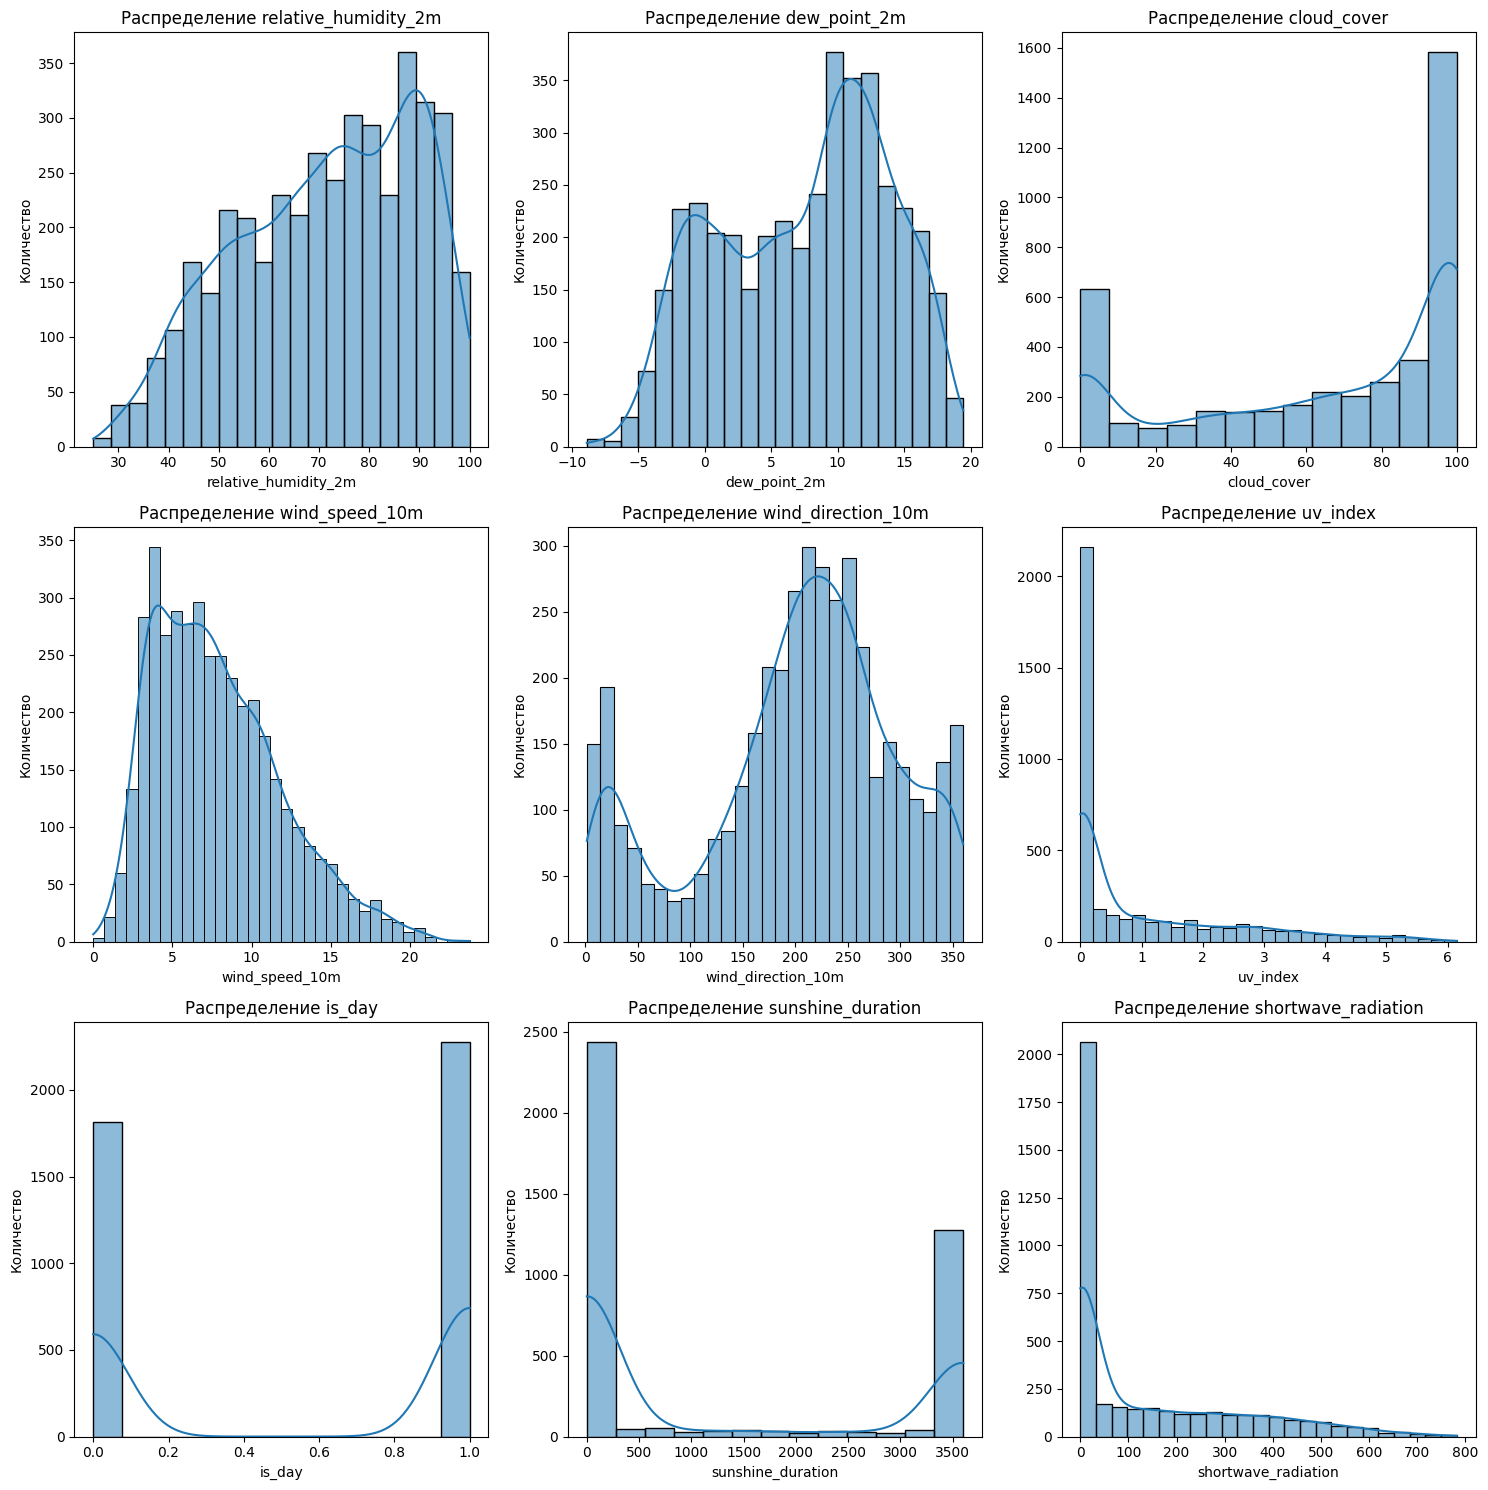

In [6]:
# визуализация распределения признаков
def visualize_distributions(df, numeric_only=True):
    """
    Визуализирует распределение признаков в DataFrame.

    Args:
        df (pd.DataFrame): DataFrame с данными.
        numeric_only (bool, optional): Визуализировать только числовые признаки. По умолчанию True.
    """

    if numeric_only:
        numeric_cols = df.select_dtypes(include=['number']).columns
    else:
        numeric_cols = df.columns
    
    if len(numeric_cols) == 0:
      print("Нет числовых признаков для визуализации.")
      return
    
    num_cols = len(numeric_cols)
    num_rows = (num_cols + 2) // 3  # Определяем количество строк для подграфиков

    plt.figure(figsize=(15, 5 * num_rows)) # Делаем размеры рисунка побольше

    for i, column in enumerate(numeric_cols, 1):
        plt.subplot(num_rows, 3, i) # Создаем подграфик на каждой итерации
        sns.histplot(df[column], kde=True)  # Гистограмма с KDE (оценка плотности ядра)
        plt.title(f'Распределение {column}') # Выводим заголовок к графику
        plt.xlabel(column) # Выводим название оси Х
        plt.ylabel("Количество") # Выводим название оси Y

    plt.tight_layout()  # Автоматически регулирует расположение графиков
    plt.show()


# Визуализируем распределения числовых признаков
visualize_distributions(df.drop(columns=['target']))


In [7]:
# # применение логарифмирования для признаков с плохим распределением
# bad_list = ['cloud_cover',
#        'et0_fao_evapotranspiration', 'sunshine_duration',
#        'shortwave_radiation_instant']

# for col in tqdm(bad_list):
#     df[col] = df[col].apply(lambda x: np.log10(x + 1))

# visualize_distributions(df.drop(columns=['target']))

interval columns not set, guessing: ['target', 'relative_humidity_2m', 'dew_point_2m', 'cloud_cover', 'wind_speed_10m', 'wind_direction_10m', 'uv_index', 'is_day', 'sunshine_duration', 'shortwave_radiation']


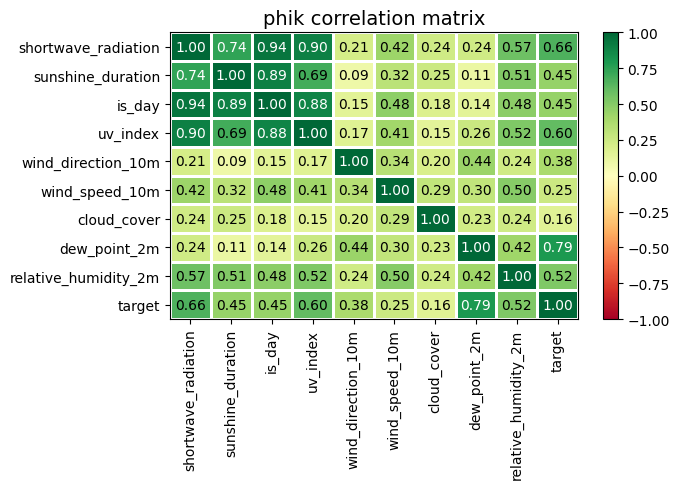

In [8]:
phik_matrix = df.phik_matrix()

plot_correlation_matrix(phik_matrix.values,
                        x_labels = phik_matrix.columns,
                        y_labels = phik_matrix.index,
                        title = 'phik correlation matrix'
)

In [9]:
# df.drop(columns = ['temperature_2m', 'sunshine_duration', 'shortwave_radiation_instant'], inplace = True)
df

,target,relative_humidity_2m,dew_point_2m,cloud_cover,wind_speed_10m,wind_direction_10m,uv_index,is_day,sunshine_duration,shortwave_radiation
0,13.0040,79.0,9.446486,100.0,8.905908,345.963700,1.90,1.0,699.35077,332.0
1,16.2040,62.0,8.914721,100.0,10.464798,3.945108,0.25,1.0,0.00000,73.0
2,13.5040,82.0,10.490725,50.0,3.396233,327.994660,0.00,0.0,0.00000,0.0
3,11.8540,95.0,11.078381,24.0,4.072935,135.000100,0.00,0.0,0.00000,0.0
4,20.3040,60.0,12.285676,0.0,7.594208,328.570500,0.40,1.0,3600.00000,163.0
...,...,...,...,...,...,...,...,...,...,...
4084,19.0040,51.0,8.637112,97.0,12.889810,35.909817,1.75,1.0,3600.00000,378.0
4085,21.9535,71.0,16.455479,100.0,9.346143,164.357700,3.30,1.0,3144.71100,323.0
4086,1.3035,91.0,-0.003951,87.0,2.545584,261.870000,0.00,0.0,0.00000,0.0
4087,17.1540,76.0,12.887712,100.0,7.289445,212.905240,2.90,1.0,3600.00000,430.0


interval columns not set, guessing: ['relative_humidity_2m', 'dew_point_2m', 'cloud_cover', 'wind_speed_10m', 'wind_direction_10m', 'uv_index', 'is_day', 'sunshine_duration', 'shortwave_radiation']


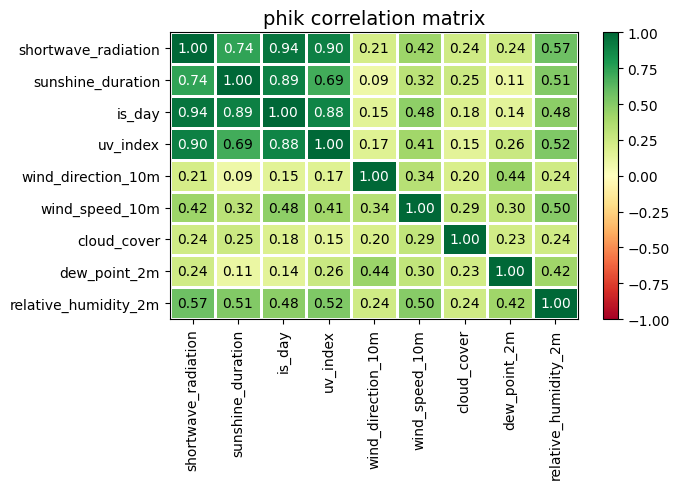

In [10]:
phik_matrix = df.drop(columns=['target']).phik_matrix()

plot_correlation_matrix(phik_matrix.values,
                        x_labels = phik_matrix.columns,
                        y_labels = phik_matrix.index,
                        title = 'phik correlation matrix'
)

# data to training dataset

In [11]:
X = df.drop(columns = ['target'])
X

,relative_humidity_2m,dew_point_2m,cloud_cover,wind_speed_10m,wind_direction_10m,uv_index,is_day,sunshine_duration,shortwave_radiation
0,79.0,9.446486,100.0,8.905908,345.963700,1.90,1.0,699.35077,332.0
1,62.0,8.914721,100.0,10.464798,3.945108,0.25,1.0,0.00000,73.0
2,82.0,10.490725,50.0,3.396233,327.994660,0.00,0.0,0.00000,0.0
3,95.0,11.078381,24.0,4.072935,135.000100,0.00,0.0,0.00000,0.0
4,60.0,12.285676,0.0,7.594208,328.570500,0.40,1.0,3600.00000,163.0
...,...,...,...,...,...,...,...,...,...
4084,51.0,8.637112,97.0,12.889810,35.909817,1.75,1.0,3600.00000,378.0
4085,71.0,16.455479,100.0,9.346143,164.357700,3.30,1.0,3144.71100,323.0
4086,91.0,-0.003951,87.0,2.545584,261.870000,0.00,0.0,0.00000,0.0
4087,76.0,12.887712,100.0,7.289445,212.905240,2.90,1.0,3600.00000,430.0


In [12]:
y = df.target
y

0       13.0040
1       16.2040
2       13.5040
3       11.8540
4       20.3040
         ...   
4084    19.0040
4085    21.9535
4086     1.3035
4087    17.1540
4088    10.9035
Name: target, Length: 4089, dtype: float64

In [13]:
quantile_bins = pd.qcut(y, q=20, precision=1, labels=False)
quantile_bins.head(), quantile_bins.tail()

(0     9
 1    13
 2    10
 3     8
 4    17
 Name: target, dtype: int64,
 4084    16
 4085    18
 4086     0
 4087    14
 4088     7
 Name: target, dtype: int64)

In [14]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=42, stratify=quantile_bins)

# catboost + optuna

In [15]:
def objective(trial):
    # Определение пространства поиска гиперпараметров
    params = {
        'iterations': trial.suggest_int('iterations', 100, 5000),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
        'depth': trial.suggest_int('depth', 2, 10),
        'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-8, 100.0),
        'border_count': trial.suggest_int('border_count', 32, 255),
        'random_strength': trial.suggest_uniform('random_strength', 0.5, 50),
        'grow_policy': trial.suggest_categorical('grow_policy', ['SymmetricTree', 'Depthwise', 'Lossguide']),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 50),
        'bootstrap_type': trial.suggest_categorical('bootstrap_type', ['Bayesian', 'Bernoulli', 'MVS']),
        'task_type': 'CPU',  # Или 'GPU', если вы хотите использовать GPU
        'verbose': 0
    }

    # Создание и обучение модели
    model = CatBoostRegressor(**params)
    model.fit(X_train, y_train)

    # Оценка модели на тестовой выборке
    y_pred = model.predict(X_test)
    rmse = root_mean_squared_error(y_test, y_pred)
    
    return rmse

In [16]:
# Создание объекта исследования
study = optuna.create_study(direction='minimize')

[I 2024-12-15 22:55:01,321] A new study created in memory with name: no-name-84c62a1e-3100-4854-9fee-f53229688805


In [17]:
# Запуск оптимизации
study.optimize(objective, n_trials=200)

[I 2024-12-15 22:55:03,072] Trial 0 finished with value: 0.26066932788615654 and parameters: {'iterations': 1631, 'learning_rate': 0.16510692584347866, 'depth': 2, 'l2_leaf_reg': 7.362804092556786e-07, 'border_count': 173, 'random_strength': 14.941826684384168, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 47, 'bootstrap_type': 'Bernoulli'}. Best is trial 0 with value: 0.26066932788615654.
[I 2024-12-15 22:55:09,891] Trial 1 finished with value: 0.25821626078689486 and parameters: {'iterations': 1763, 'learning_rate': 0.010512552513370077, 'depth': 6, 'l2_leaf_reg': 1.0474328575652277e-08, 'border_count': 199, 'random_strength': 22.907277493456885, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 20, 'bootstrap_type': 'Bayesian'}. Best is trial 1 with value: 0.25821626078689486.
[I 2024-12-15 22:55:13,343] Trial 2 finished with value: 0.5800765699108793 and parameters: {'iterations': 1522, 'learning_rate': 0.20706484673107084, 'depth': 5, 'l2_leaf_reg': 0.00021328562847880146, 'border

In [18]:
study.best_params

{'iterations': 3615,
 'learning_rate': 0.040278950173894025,
 'depth': 3,
 'l2_leaf_reg': 5.068227999702688e-07,
 'border_count': 237,
 'random_strength': 0.5710100075736467,
 'grow_policy': 'SymmetricTree',
 'min_data_in_leaf': 32,
 'bootstrap_type': 'MVS'}

In [19]:
# Обучение финальной модели с лучшими гиперпараметрами
best_params = study.best_params
best_model = CatBoostRegressor(**best_params, verbose=52)
best_model.fit(X_train, y_train)

0:	learn: 6.3070793	total: 1.25ms	remaining: 4.53s
52:	learn: 1.8007640	total: 59.1ms	remaining: 3.97s
104:	learn: 0.7456479	total: 115ms	remaining: 3.83s
156:	learn: 0.4128826	total: 167ms	remaining: 3.68s
208:	learn: 0.2939480	total: 222ms	remaining: 3.61s
260:	learn: 0.2304247	total: 277ms	remaining: 3.56s
312:	learn: 0.1940482	total: 333ms	remaining: 3.52s
364:	learn: 0.1716933	total: 387ms	remaining: 3.44s
416:	learn: 0.1560906	total: 440ms	remaining: 3.37s
468:	learn: 0.1454933	total: 493ms	remaining: 3.3s
520:	learn: 0.1365459	total: 546ms	remaining: 3.24s
572:	learn: 0.1291408	total: 597ms	remaining: 3.17s
624:	learn: 0.1233734	total: 649ms	remaining: 3.11s
676:	learn: 0.1183896	total: 702ms	remaining: 3.05s
728:	learn: 0.1142537	total: 753ms	remaining: 2.98s
780:	learn: 0.1098026	total: 805ms	remaining: 2.92s
832:	learn: 0.1061611	total: 857ms	remaining: 2.86s
884:	learn: 0.1028392	total: 911ms	remaining: 2.81s
936:	learn: 0.0999841	total: 963ms	remaining: 2.75s
988:	learn: 0.

# predict

In [20]:
pred_df

,relative_humidity_2m,dew_point_2m,cloud_cover,wind_speed_10m,wind_direction_10m,uv_index,is_day,sunshine_duration,shortwave_radiation
index,,,,,,,,,
0,54.0,6.139822,0.0,2.520000,180.000000,0.05,0.0,0.0000,6.0
1,92.0,9.208817,100.0,9.504273,245.376450,0.00,1.0,0.0000,17.0
2,89.0,15.768355,98.0,4.104631,217.875050,0.00,0.0,0.0000,0.0
3,64.0,13.176939,13.0,6.569383,350.537750,1.30,1.0,3600.0000,143.0
4,62.0,12.596930,100.0,9.726664,218.991000,2.95,1.0,2469.8354,273.0
...,...,...,...,...,...,...,...,...,...
1018,96.0,-1.404214,72.0,5.804825,262.875100,0.05,1.0,0.0000,10.0
1019,95.0,16.494910,100.0,1.835647,78.690100,0.00,0.0,0.0000,0.0
1020,63.0,9.719828,97.0,14.512064,29.744795,4.55,1.0,3600.0000,545.0


In [21]:
pred = best_model.predict(pred_df)
pred

array([15.45266798, 10.41879318, 17.60263844, ..., 16.89170818,
       22.65321193,  2.1970823 ])

In [22]:
pred_df['target'] = pred
pred_df

,relative_humidity_2m,dew_point_2m,cloud_cover,wind_speed_10m,wind_direction_10m,uv_index,is_day,sunshine_duration,shortwave_radiation,target
index,,,,,,,,,,
0,54.0,6.139822,0.0,2.520000,180.000000,0.05,0.0,0.0000,6.0,15.452668
1,92.0,9.208817,100.0,9.504273,245.376450,0.00,1.0,0.0000,17.0,10.418793
2,89.0,15.768355,98.0,4.104631,217.875050,0.00,0.0,0.0000,0.0,17.602638
3,64.0,13.176939,13.0,6.569383,350.537750,1.30,1.0,3600.0000,143.0,20.200149
4,62.0,12.596930,100.0,9.726664,218.991000,2.95,1.0,2469.8354,273.0,20.109809
...,...,...,...,...,...,...,...,...,...,...
1018,96.0,-1.404214,72.0,5.804825,262.875100,0.05,1.0,0.0000,10.0,-0.865534
1019,95.0,16.494910,100.0,1.835647,78.690100,0.00,0.0,0.0000,0.0,17.277584
1020,63.0,9.719828,97.0,14.512064,29.744795,4.55,1.0,3600.0000,545.0,16.891708


In [23]:
pred_df.columns.drop('target')

Index(['relative_humidity_2m', 'dew_point_2m', 'cloud_cover', 'wind_speed_10m',
       'wind_direction_10m', 'uv_index', 'is_day', 'sunshine_duration',
       'shortwave_radiation'],
      dtype='object')

In [24]:
pred_df.drop(columns = list(pred_df.columns.drop('target')), inplace = True)
pred_df

,target
index,
0,15.452668
1,10.418793
2,17.602638
3,20.200149
4,20.109809
...,...
1018,-0.865534
1019,17.277584
1020,16.891708


In [25]:
pred_df.to_csv('sub.csv')

In [82]:
pred_df = pd.read_csv('sub.csv', index_col=0)
pred_df

,target
index,
0,15.452668
1,10.418793
2,17.602638
3,20.200149
4,20.109809
...,...
1018,-0.865534
1019,17.277584
1020,16.891708


In [83]:
pred_df['target'] = pred_df['target'] + 0.00248899
pred_df

,target
index,
0,15.455157
1,10.421282
2,17.605127
3,20.202638
4,20.112298
...,...
1018,-0.863045
1019,17.280073
1020,16.894197


In [84]:
pred_df.to_csv('sub123.csv')